In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
from scipy.signal import argrelextrema
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import pickle
import datetime
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt
from scipy.stats import binned_statistic


In [2]:
dir = '../../data/rothera/20230923'

In [3]:
freq='Ka'
listfiles = os.listdir(dir)
files = sorted([f for f in listfiles if f'{freq}-Scat' in f])

Text(0, 0.5, 'y distance (m)')

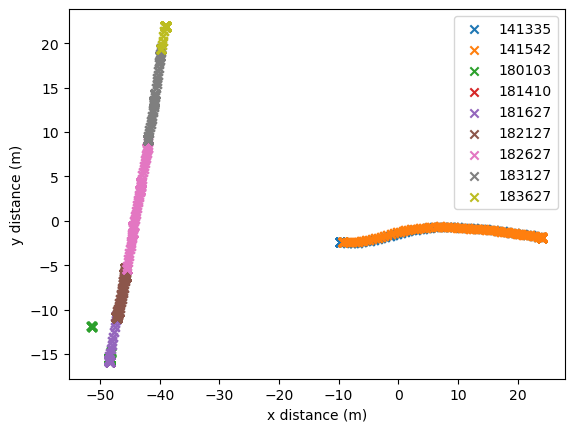

In [4]:
x,y=kt.plot_pos(files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531

xy_dict = {}

for f in files:

    x,y = kt.plot_pos(f,dir,x0=x0,y0=y0)

    xy_dict[f] = (x,y)
    
plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')

[81, 347]

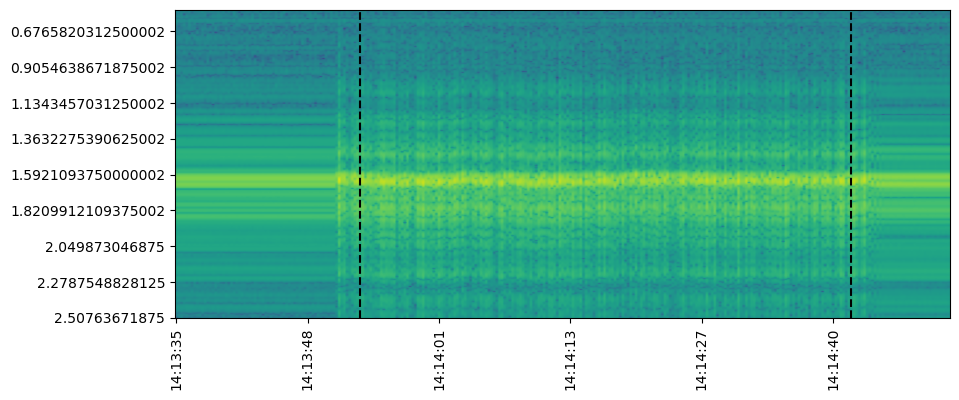

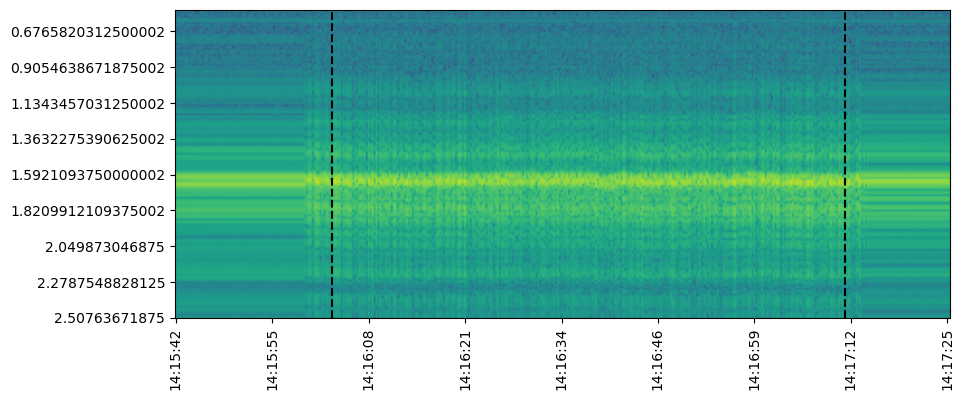

In [5]:
vlines = [(datetime.datetime(2023,9,23,14,13,53),datetime.datetime(2023,8,23,14,14,42)),
          (datetime.datetime(2023,9,23,14,16,3),datetime.datetime(2023,8,23,14,17,12)),
         ]

kt.plot_file(files[0],freq.lower(),dir,
                 vlines=vlines[0])

kt.plot_file(files[1],freq.lower(),dir,
                 vlines=vlines[1])

In [6]:
d = Dataset(f'{dir}/{files[0]}')
near=kt.get_range_index(1.3,d['range'])
far=kt.get_range_index(2,d['range'])
near,far

(736, 889)

In [7]:
nrcs_list = []
vv_list = []

for i in [0,1]:

    foi = files[i]
    x,y=xy_dict[foi]

    d = Dataset(f'{dir}/{foi}')

    time_offset_s=0
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

    mintime = kt.get_time_index(vlines[i][0],times)
    maxtime = kt.get_time_index(vlines[i][1],times)

    time_offset_s=0
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

    nrcs = pd.DataFrame(kt.get_nrcs(d,freq.lower()))

    x_ = 0; y_ = 0

    along_track = np.sqrt((x-x_)**2 + (y-y_)**2)
    xdiff = np.diff(x)
    ydiff = np.diff(y)
    speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
    speed=list(speed)+[0]
    nrcs['along_track']=along_track
    nrcs['speed']=speed
    nrcs['xtilt']=np.array(d['cross_tilt'])
    nrcs['atilt']=np.array(d['along_tilt'])
    # print(nrcs.shape)
    nrcs = nrcs.iloc[mintime:maxtime]
    nrcs = nrcs.sort_values('along_track').reset_index()
    nrcs_list.append(nrcs)

    vv= np.array(d['vv_power_decon0'])[near:far,mintime:maxtime]
    vv_list.append(vv)
    
    
    # hv = np.array(d['hv_power_decon0'])[near:far,mintime:maxtime]

    
ranges = np.array(d['range'])
near = kt.get_range_index(ranges,1.3)
far = kt.get_range_index(ranges,2)
rel_ranges=ranges[near:far]

vv = np.hstack(vv_list)
nrcs = pd.concat(nrcs_list)

In [8]:
multipeak=[]
list_of_dfs = []
peak_power_ratios = []
range_to_nearpeak = []
range_to_farpeak = []
range_to_monopeaks = []
interpeak_range = []

for i in np.arange(nrcs.shape[0]):
    
    power = vv[:,i]
    # hvpower = hv[:,i]
    
    # Get indices of local maxima
    max_inds = argrelextrema(power, np.greater)[0]
    # Make a list of dictionaries that includes the range_index, range, and power of each local maximum.
    list_of_dicts_for_df = [{'ind':q,'power':power[q],'range':rel_ranges[q]} for q in max_inds]
    
    
    # Sort dataframe so most powerful peaks at top
    df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False)
    # Take two most powerful peaks
    top_powers_df = df.iloc[:2]
    # Sort the two by range
    df_by_range = top_powers_df.sort_values('range',ascending=True)
    top_powers=list(df_by_range['power'])
    
    peak1=top_powers[0] #Nearest of the two most powerful peaks in range
    peak2=top_powers[1]
    # Calculate ratio of second peak power to first peak power
    peak_power_ratios.append(peak2/peak1)
    
    # Calculate ratio of second-largest peak to largest peak
    
    top_powers = list(top_powers_df['power'])

    peak1=top_powers[0]
    peak2=top_powers[1]
    multipeakiness=1 if peak2/peak1>0.05 else 0
    multipeak.append(multipeakiness)
    
    if multipeakiness==0:
        range_to_monopeaks.append(float(top_powers_df['range'].iloc[0]))
    else:
        range_to_nearpeak.append(float(df_by_range['range'].iloc[0]))
        range_to_farpeak.append(float(df_by_range['range'].iloc[-1]))
        interpeak_range.append(float(df_by_range['range'].iloc[-1])-float(df_by_range['range'].iloc[0]))
    
nrcs['multipeak']=multipeak
nrcs['power_ratios']=peak_power_ratios
nrcs=nrcs.reset_index()

In [9]:
bw = np.diff(d['range'])[-2]
_ = sorted(list(set(interpeak_range)))
x = np.arange(_[0],_[-1]+0.0001,bw)

0.037806668727517985


Text(0, 0.5, 'Number')

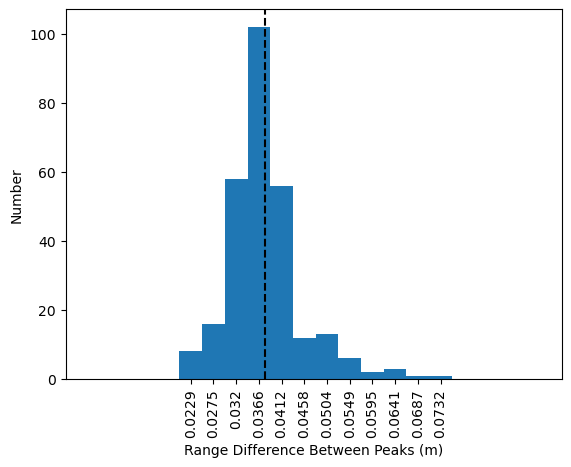

In [10]:

plt.hist(interpeak_range,bins=rel_ranges-rel_ranges[0])
plt.xticks(x+bw/2,labels=np.round(x,decimals=4),rotation=90)
mean = np.nanmean(interpeak_range)
print(mean)
plt.axvline(mean+bw/2,color='k',ls='--')
plt.xlim(0,0.1)
plt.xlabel('Range Difference Between Peaks (m)')
plt.ylabel('Number')

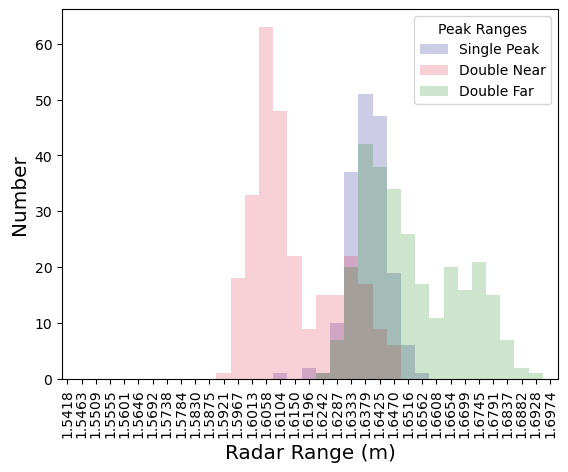

In [23]:
plt.hist(range_to_monopeaks,bins=np.array(rel_ranges)-bw/2,alpha=0.2,label='Single Peak',color='darkblue')
plt.hist(range_to_nearpeak,bins=np.array(rel_ranges)-bw/2,alpha=0.2,label='Double Near',color='crimson')
plt.hist(range_to_farpeak,bins=np.array(rel_ranges)-bw/2,alpha=0.2,label='Double Far',color='green')
# plt.axvline(np.nanmean(range_to_farpeak),color='green',ls='--')
# plt.axvline(np.nanmean(range_to_nearpeak),color='crimson',ls='--')
# plt.axvline(np.nanmean(range_to_monopeaks),color='darkblue',ls='--')
plt.xticks(rel_ranges,rotation=90)
plt.xlim(1.54,1.7)
plt.ylabel('Number',fontsize='x-large')
plt.xlabel('Radar Range (m)',fontsize='x-large')
plt.legend(title='Peak Ranges')
plt.show()

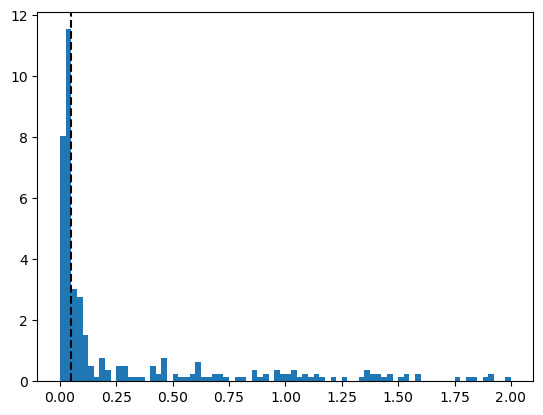

In [12]:
plt.hist(nrcs['power_ratios'],bins=np.arange(0,2.01,0.025),density=True)
plt.axvline(0.05,color='k',ls='--')

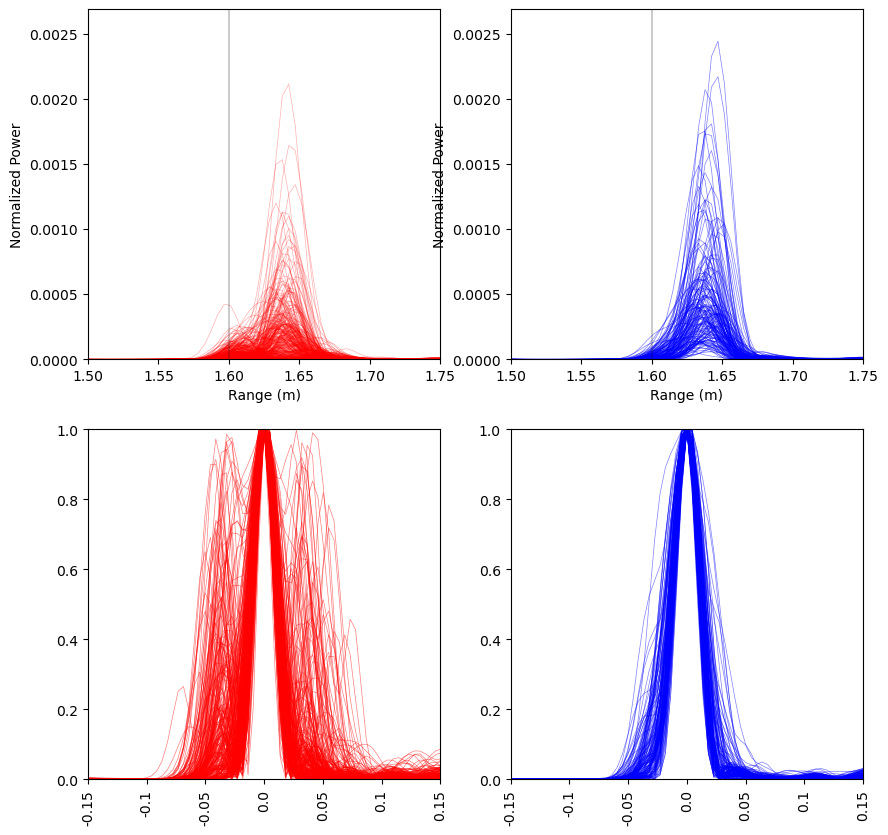

In [13]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

ax1,ax2,ax3,ax4=axs.reshape(-1)

max_powers = []

for i in np.arange(nrcs.shape[0]):
    
    ratio = nrcs['power_ratios'][i]
    
    power = vv[:,i]
    # hvpower = hv[:,i]
    max_inds = argrelextrema(power, np.greater)[0]
    list_of_dicts_for_df = [{'ind':q,'power':power[q],'range':rel_ranges[q]} for q in max_inds]
    df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False)
    
    if ratio >0.05:
        spec=0
        c='r'
        ax1.plot(rel_ranges,power,color=c,lw=0.5,alpha=0.3)
        # ax1.plot(rel_ranges,hvpower/np.max(hvpower),color='k',lw=0.5,alpha=0.5)

    else:
        spec=1
        c='b'
        ax2.plot(rel_ranges,power,color=c,lw=0.5,alpha=0.5)
        
    max_powers.append(np.max(power))
    
    # Now align max peaks and plot again
    range_largest_peak = float(df['range'].iloc[0])
    adj_ranges=rel_ranges-range_largest_peak

    if spec==0:# Align first peak
        ax3.plot(adj_ranges,power/np.max(power),lw=0.5,alpha=0.5,c='r')
    else:
        ax4.plot(adj_ranges,power/np.max(power),lw=0.5,alpha=0.5,c='b')
    
    
    

for ax in [ax1,ax2]:
    ax.axvline(1.6,color='k',lw=0.3)
    ax.set_ylabel('Normalized Power')
    ax.set_xlabel('Range (m)')
    ax.set_ylim(0,np.max(max_powers)*1.1)
    ax.set_xlim(1.5,1.75)
    
for ax in [ax3,ax4]:
    tix=np.arange(-0.15,0.16,0.05)
    ax.set_xticks(tix,labels=np.round(tix,decimals=2),rotation=90)
    ax.set_xlim(-0.15,0.15)
    ax.set_ylim(0,1)
plt.show()

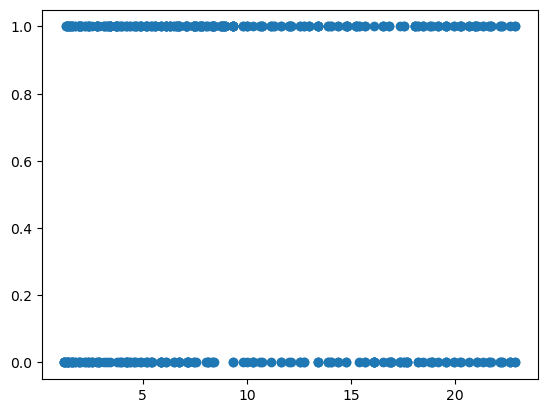

In [18]:
plt.scatter(nrcs['along_track'],nrcs['multipeak'])

In [20]:
nrcs_nonspec = nrcs[nrcs['multipeak']==1]
nrcs_spec = nrcs[nrcs['multipeak']==0]
nrcs_nonspec.shape[0],nrcs_spec.shape[0]

(278, 175)

Text(0, 0.5, 'Number')

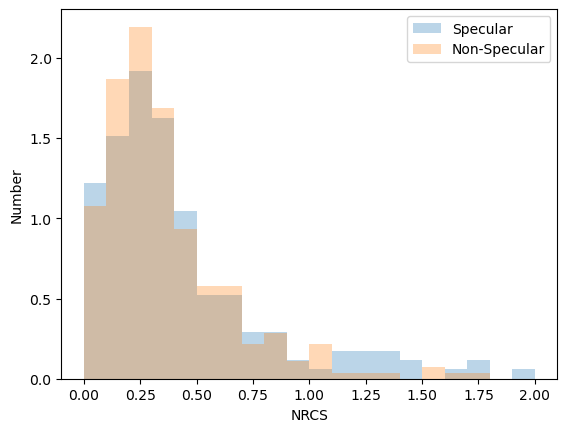

In [17]:
bins=np.arange(0,2.01,0.1)
plt.hist(nrcs_spec['vv'],label='Specular',density=True,alpha=0.3,bins=bins)
plt.hist(nrcs_nonspec['vv'],label='Non-Specular',density=True,alpha=0.3,bins=bins)
plt.legend()
plt.xlabel('NRCS')
plt.ylabel('Number')

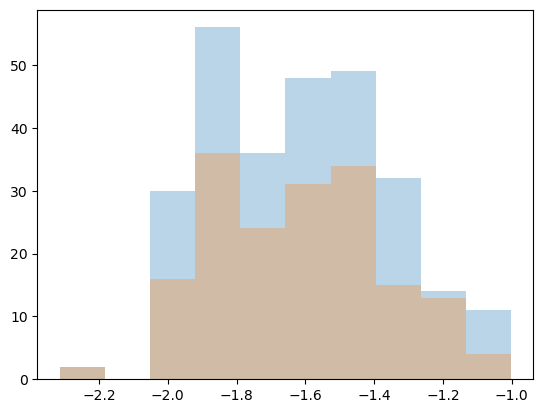

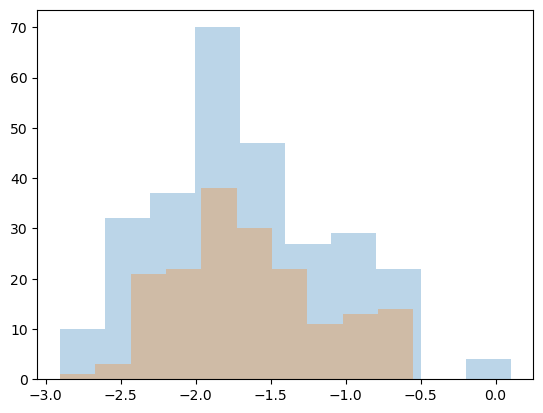

In [16]:
plt.hist(nrcs_nonspec['xtilt'],alpha=0.3)
plt.hist(nrcs_spec['xtilt'],alpha=0.3)
plt.show()
plt.hist(nrcs_nonspec['atilt'],alpha=0.3)
plt.hist(nrcs_spec['atilt'],alpha=0.3)
plt.show()

Text(0, 0.5, 'Number')

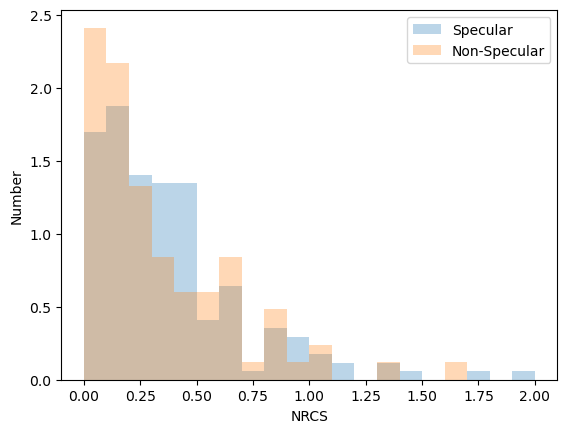